In [1]:
from data import get_data, get_processed_data
from train_test import train, output_to_accu, test
from helpers import plot_cm, count_parameters
from models import MLP
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import shap

from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
_, target_prices, features = get_data()

training_window = 10

X, y, = get_processed_data(features, target_prices, training_window)

In [3]:
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]
print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

X_mean = X_train.mean(dim=[0, 1], keepdim=True)
X_std = X_train.std(dim=[0, 1], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

Number of train sample : 2088
Number of test sample : 523


In [4]:
class_count_train = np.unique(y_train.cpu(), axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test.cpu(), axis=0, return_counts=True)[1]
weights_train = torch.tensor(class_count_train / sum(class_count_train))
weights_test = torch.tensor(class_count_test / sum(class_count_test))
print('Allocation of best returns in train set :', weights_train.cpu().numpy())
print('Allocation of best returns in test set :', weights_test.cpu().numpy())

Allocation of best returns in train set : [0.505 0.495]
Allocation of best returns in test set : [0.488 0.512]


In [5]:
class MLP1(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size1=10, hidden_size2=10, hidden_size3=10):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 2)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.drop1(self.fc1(x)))
        x = self.relu2(self.drop2(self.fc2(x)))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.softmax(self.fc4(x))       

        return x

In [6]:
class MLP2(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size1=50, hidden_size2=50, hidden_size3=50):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 2)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.drop1(self.fc1(x)))
        x = self.relu2(self.drop2(self.fc2(x)))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.softmax(self.fc4(x))       

        return x

In [7]:
class MLP3(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size1=100, hidden_size2=100, hidden_size3=100):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 2)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.drop1(self.fc1(x)))
        x = self.relu2(self.drop2(self.fc2(x)))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.softmax(self.fc4(x))       

        return x

In [8]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.2
batch_size = 30
nb_epochs = 100

verbose = 3

model_name = 'ConvNet'

nbr_features = X.size(1)

model_MLP1 = MLP1(nbr_features, pdrop=dropout)
model_MLP2 = MLP2(nbr_features, pdrop=dropout)
model_MLP3 = MLP3(nbr_features, pdrop=dropout)

train(model_MLP1, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_MLP2, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_MLP3, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


In [9]:
model_MLP1.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP1, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP1, X_test, y_test):.2f} %')

model_MLP2.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP2, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP2, X_test, y_test):.2f} %')

model_MLP3.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP3, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP3, X_test, y_test):.2f} %')

 MLP Accuracy on train set : 64.46 %
 MLP Accuracy on test set : 56.98 %
 MLP Accuracy on train set : 82.52 %
 MLP Accuracy on test set : 53.35 %
 MLP Accuracy on train set : 82.71 %
 MLP Accuracy on test set : 56.21 %


In [10]:
def SHAP_barplot(model_list, X, X_test):
    
    fig, axs = plt.subplots(1, len(model_list), figsize=(20, 50))
    axs = axs.ravel()
    
    for i, model in enumerate(model_list):
        explainer = shap.DeepExplainer(model, X)
        shap_values = explainer.shap_values(X_test)

        shap_matrix = np.mean(np.mean(shap_values, axis=0), axis=0)
        shap_matrix = np.abs(shap_matrix)

        sns.barplot(ax=axs[i], x=shap_matrix, y=features.columns, color='r')

    plt.show()

In [ ]:
model_list = [model_MLP1, model_MLP2, model_MLP3]
SHAP_barplot(model_list, X_train, X_test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [79]:
def IG_barplot(model_list, X_test):  
    
    fig, axs = plt.subplots(1, len(model_list), figsize=(20,50), sharex=True, sharey=True)
    axs = axs.ravel()
    for i, model in enumerate(model_list):
        model.eval()
        ig = IntegratedGradients(model)
        attr1 = np.abs(ig.attribute(X_test, target=0, return_convergence_delta=False).detach().numpy())
        attr2 = np.abs(ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy())
        attr = (attr1 + attr2) / 2
        std = np.std(attr, axis=0)
        
        attr_matrix = np.abs(np.mean(attr, axis=0))

        sns.barplot(ax=axs[i], y=features.columns, x=attr_matrix, yerr=std, color='r', orient='h')
        axs[i].tick_params(length=0)

    plt.show()

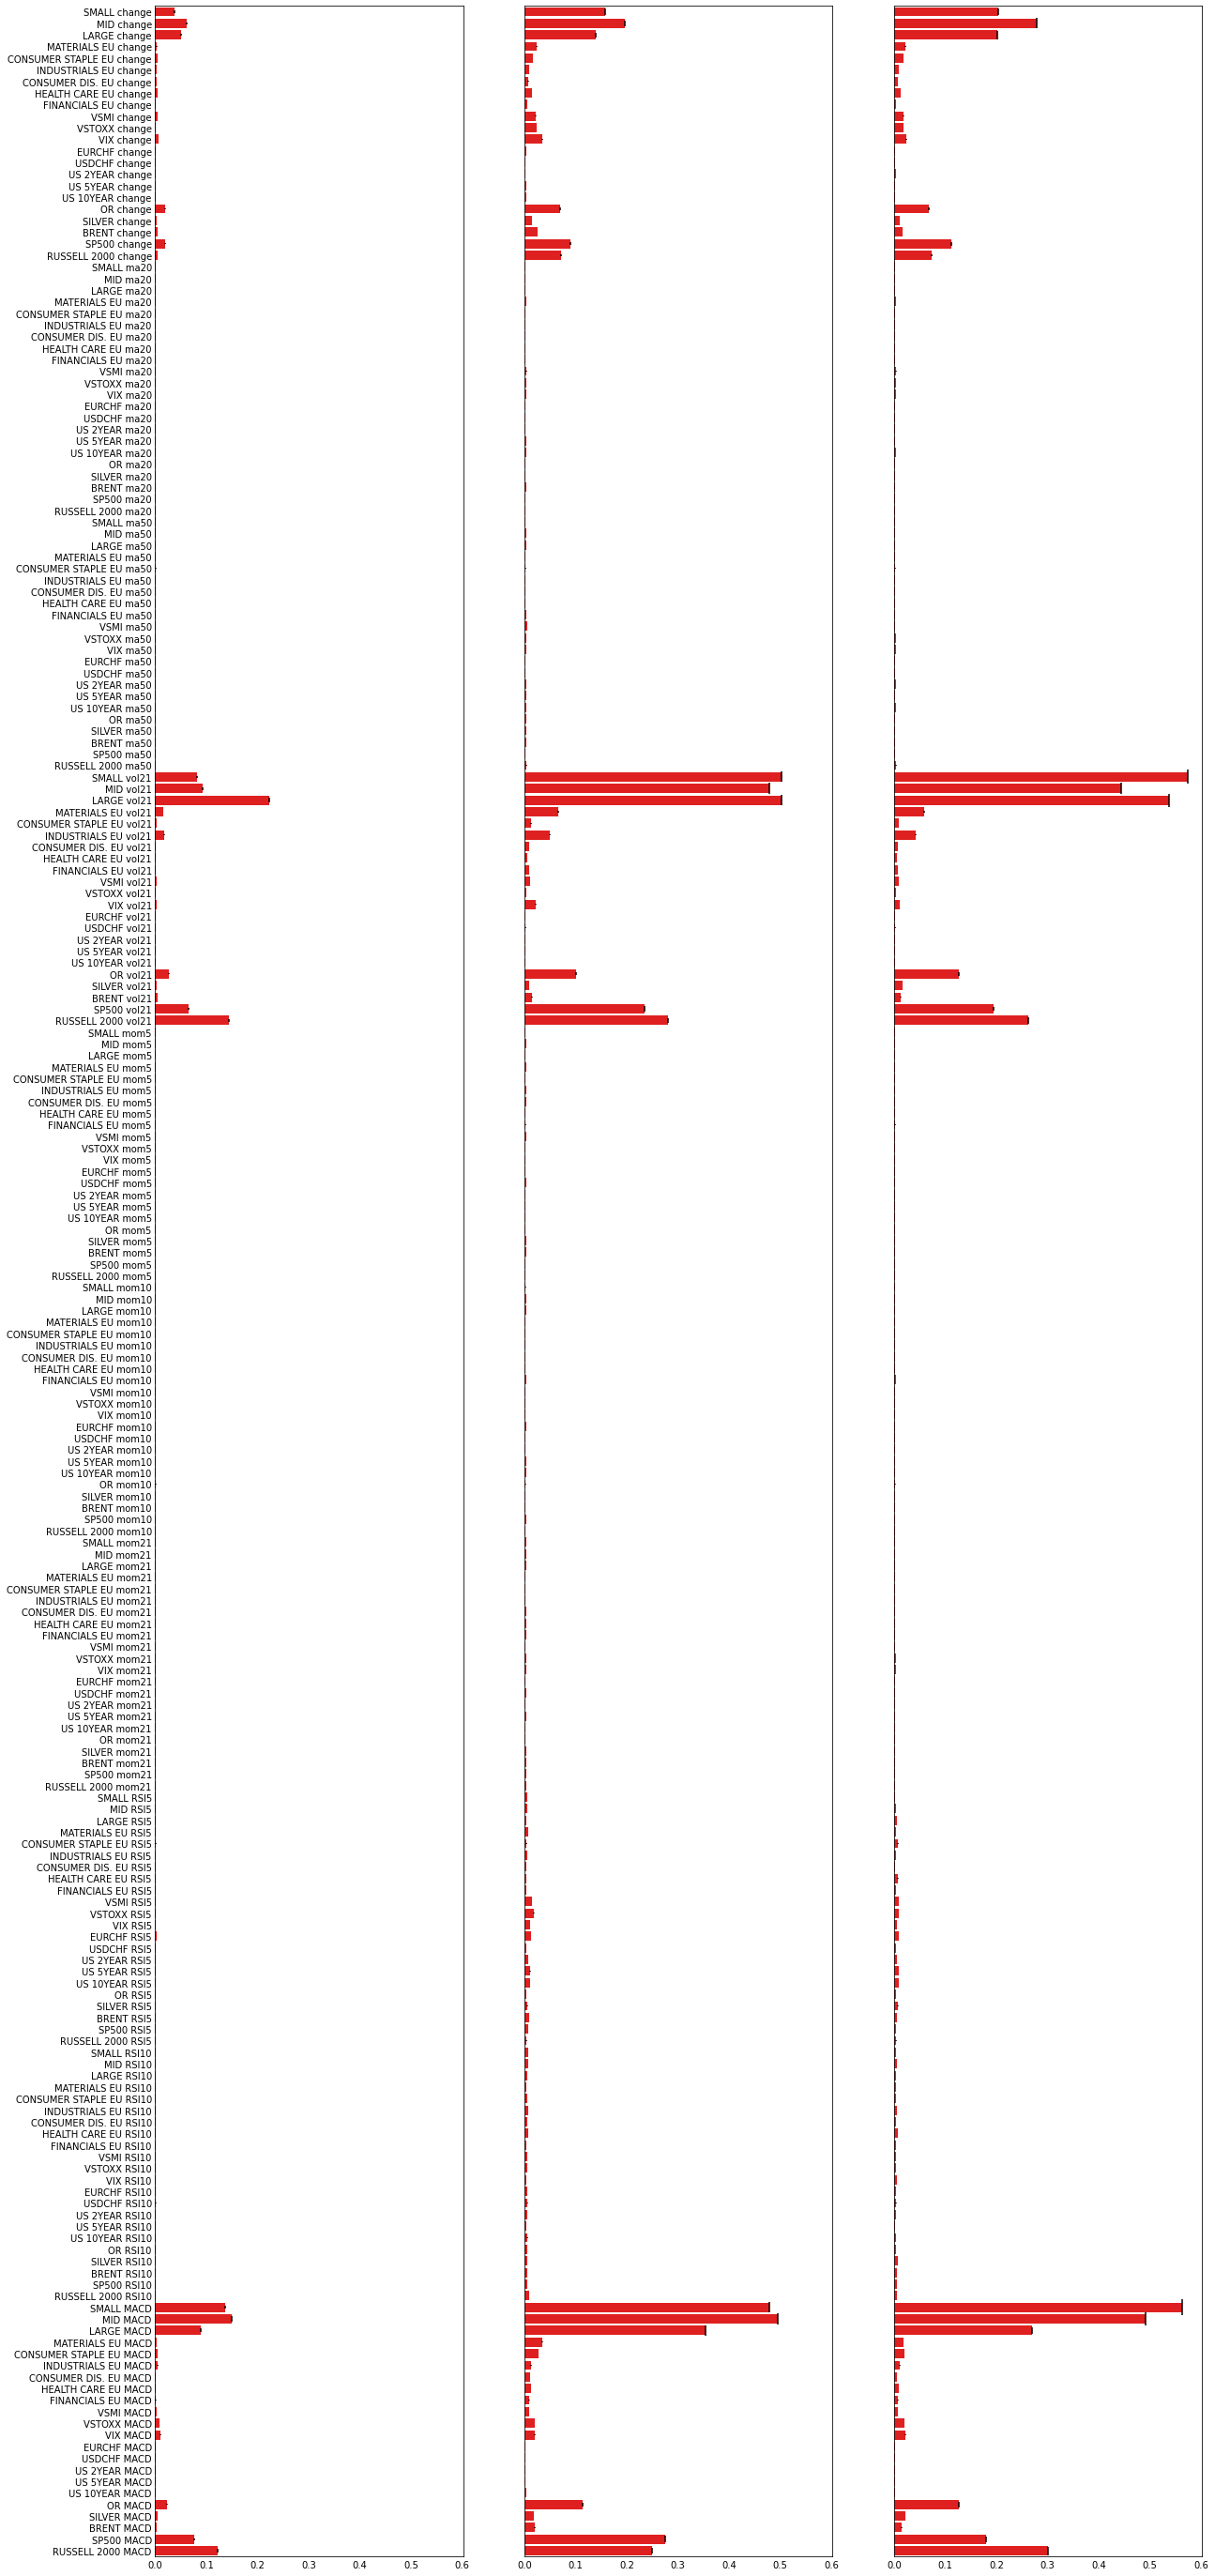

In [80]:
model_list = [model_MLP1, model_MLP2, model_MLP3]
IG_barplot(model_list, X_test)

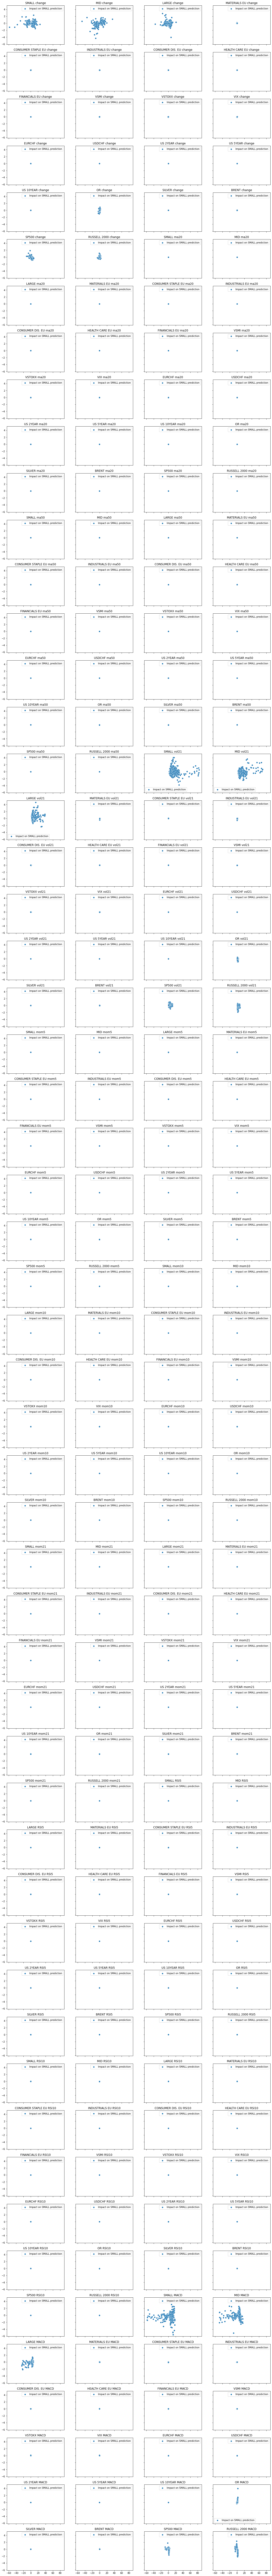

In [27]:
ig = IntegratedGradients(model_MLP1)
fig, axs = plt.subplots(55, 4, figsize=(20, 200), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    x = X_test[:, i]
    y1 = ig.attribute(X_test, target=0, return_convergence_delta=False).detach().numpy()[:, i]
    # y2 = ig.attribute(X_test, target=1, return_convergence_delta=False).detach().numpy()[:, 1]
    
    sns.scatterplot(ax=axs[i], x=x, y=y1, label='Impact on SMALL prediction')
    # sns.scatterplot(ax=ax, x=x, y=y2, label='Impact on LARGE prediction')
    axs[i].set_title(feature)
plt.show()

# Random Forest feature importance

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size= 0.2, shuffle=False)

In [38]:
# Number of trees in Random Forest
rf_n_estimators = list(range(50, 250, 50))

# Maximum number of levels in tree
rf_max_depth = list(range(20, 40, 5))
rf_max_depth.append(None)

# Minimum number of samples required to be at a leaf node
rf_min_samples_leaf = list(range(1, 3))

# Minimum number of samples required to split a node
rf_min_samples_split = list(range(1, 3))

rf_grid = {'n_estimators'     : rf_n_estimators,
           'max_depth'        : rf_max_depth, 
           'min_samples_leaf' : rf_min_samples_leaf, 
           'min_samples_split': rf_min_samples_split }

In [102]:
rf_default = RandomForestClassifier()

rf_random_cv = RandomizedSearchCV(estimator=rf_default, param_distributions=rf_grid, 
                                  n_iter=100, cv=5, verbose=3, scoring='accuracy')

rf_random_cv.fit(X_train,y_train)

print(rf_random_cv.best_params_)
best_param_rf = list(rf_random_cv.best_params_.values())

The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.459 total time=   1.1s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.459 total time=   1.1s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.469 total time=   1.1s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.561 total time=   1.1s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.518 total time=   1.1s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.514 total time=   2.1s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.495 total time=   2.1s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.488 total time=  

[CV 5/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=200;, score=0.475 total time=   2.3s
[CV 1/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=300;, score=0.493 total time=   3.4s
[CV 2/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=300;, score=0.476 total time=   3.3s
[CV 3/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=300;, score=0.464 total time=   3.3s
[CV 4/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=300;, score=0.525 total time=   3.2s
[CV 5/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=300;, score=0.492 total time=   3.1s
[CV 1/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=400;, score=0.488 total time=   4.1s
[CV 2/5] END max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=400;, score=0.502 total time=   4.2s
[CV 3/5] END max_depth=10, min_samples_leaf=3, min_sampl

[CV 5/5] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=400;, score=0.511 total time=   4.8s
[CV 1/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.483 total time=   1.2s
[CV 2/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.500 total time=   1.2s
[CV 3/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.481 total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.511 total time=   1.5s
[CV 5/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.516 total time=   1.5s
[CV 1/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=200;, score=0.488 total time=   2.7s
[CV 2/5] END max_depth=20, min_samples_leaf=3, min_samples_split=3, n_estimators=200;, score=0.510 total time=   2.7s
[CV 3/5] END max_depth=20, min_samples_leaf=3, min_sampl

KeyboardInterrupt: 

In [97]:
best_n_estimators, best_min_samples_split, best_min_samples_leaf, best_max_depth = best_param_rf

#rfc = RandomForestClassifier(criterion='gini',, max_depth=best_max_depth,
#                             n_estimators=best_n_estimators, min_samples_leaf=best_min_samples_leaf,
#                             min_samples_split=best_min_samples_split)

rfc = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_leaf=10, 
                             min_samples_split=20, n_estimators= 500)

rfc = rfc.fit(X_train.numpy(), y_train.numpy())
y_hat_rfc_train = rfc.predict(X_train.numpy())
y_hat_rfc_test = rfc.predict(X_test.numpy())

print('Accuracy on train set', round(100 * accuracy_score(y_hat_rfc_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_rfc_test, y_test), 2), '%')

Accuracy on train set 96.55 %
Accuracy on test set 50.48 %


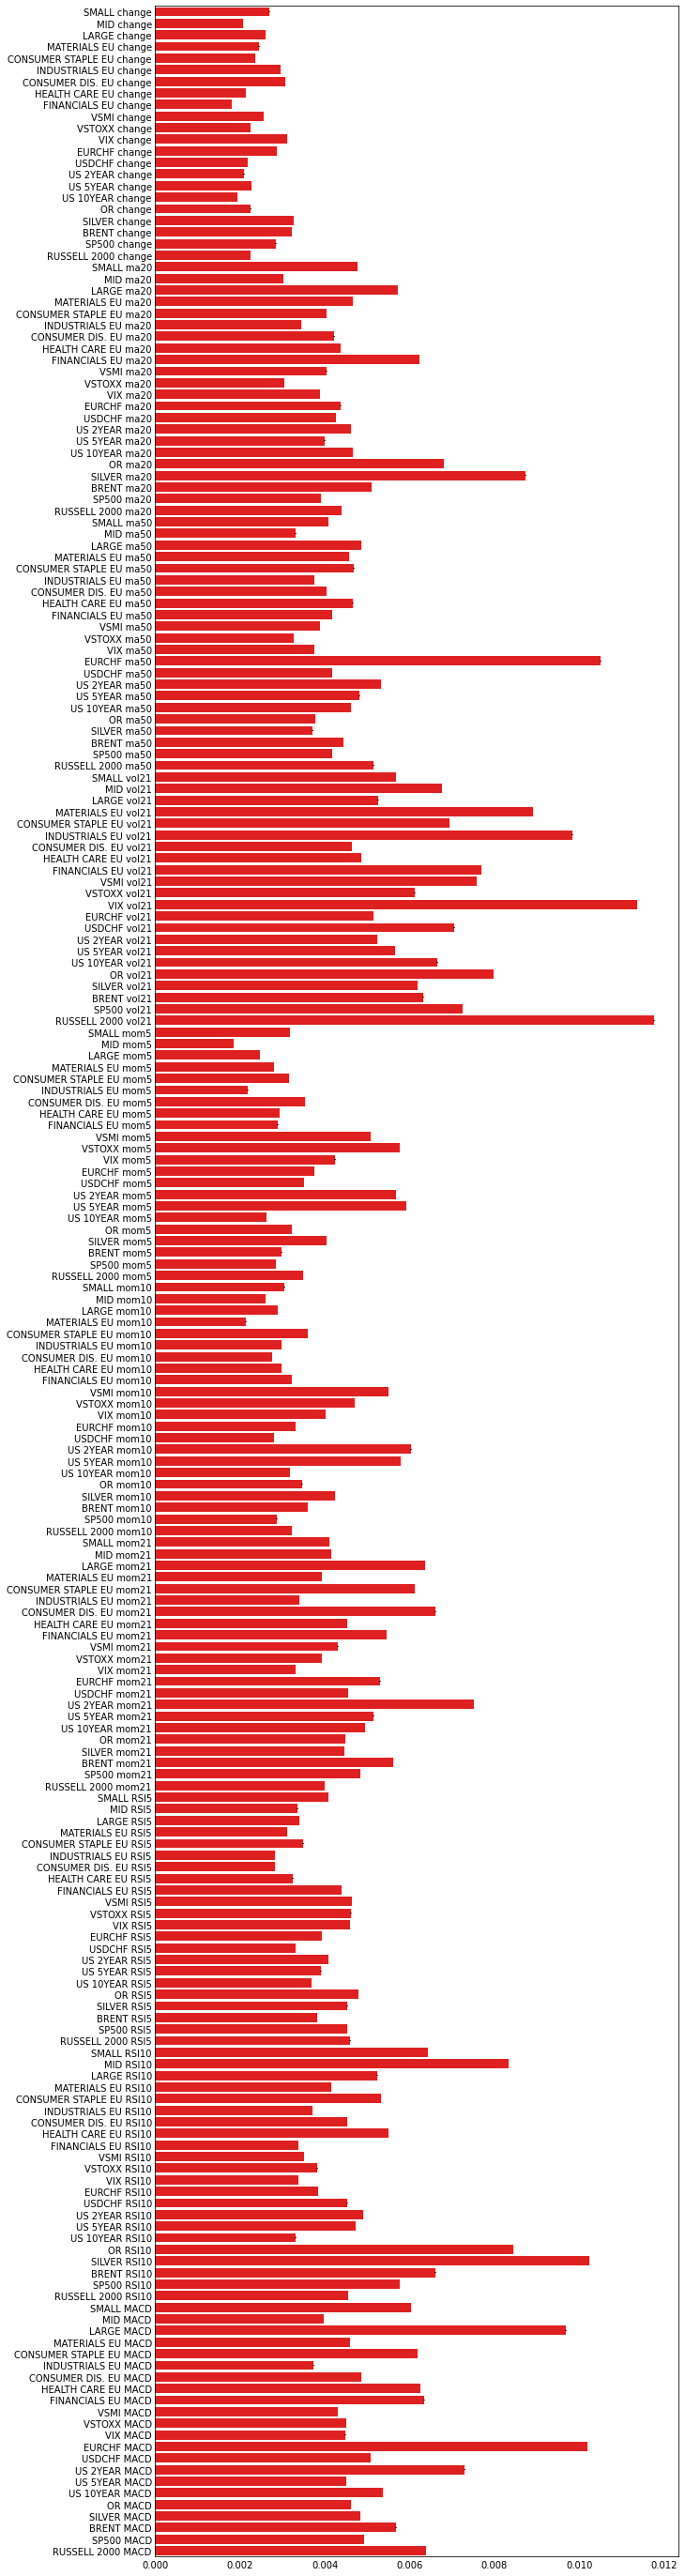

In [98]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(10, 50))
sns.barplot(y=features.columns, x=importances, color='r', yerr=std, errwidth=1)
ax.tick_params(length=0)
plt.show()

In [99]:
def SHAP_barplot_rf(model, X_test):
    
    fig, ax = plt.subplots(figsize=(10, 50))
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_matrix = np.mean(shap_values, axis=0)
    std = np.std(shap_matrix, axis=0)
    shap_matrix = np.abs(np.mean(shap_matrix, axis=0))

    sns.barplot(x=shap_matrix, y=features.columns, yerr=std, errwidth=1, color='r')
    ax.tick_params(length=0)

    plt.show()

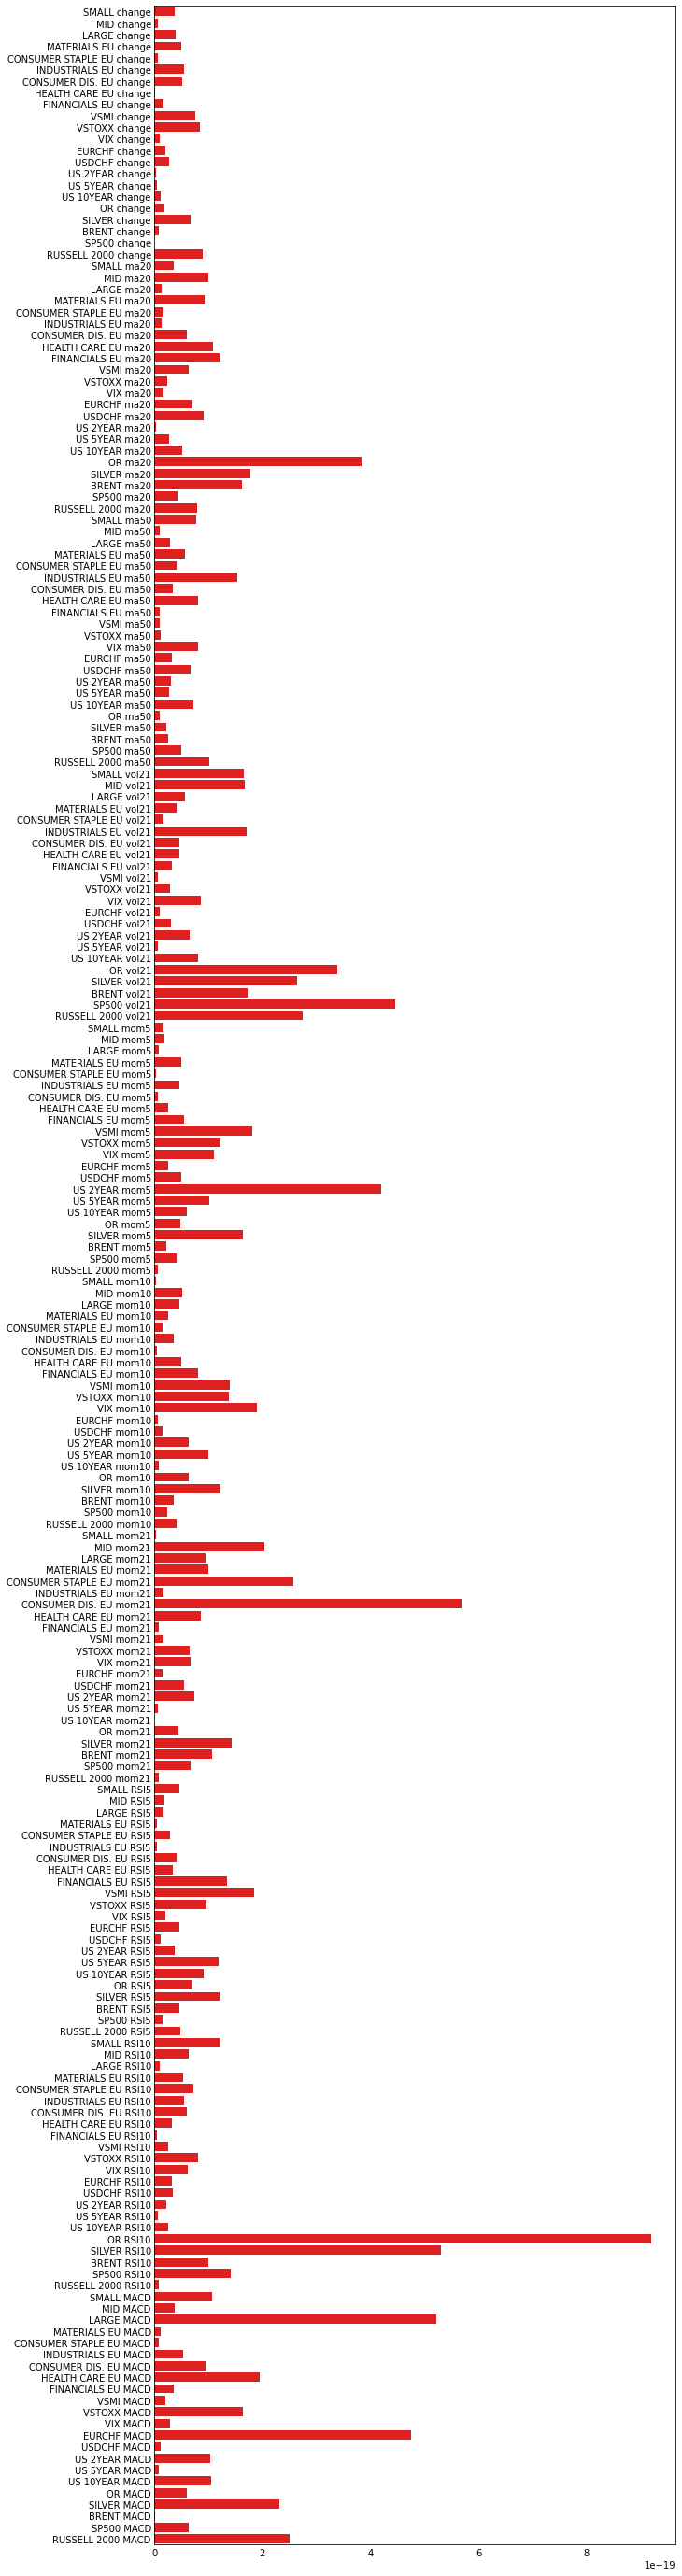

In [100]:
SHAP_barplot_rf(rfc, X_train.numpy())

# KNN feature importance